In [2]:
!pip install plotnine networkx

In [3]:
# load autobounds components used in this demo
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG
from autobounds.Query import Query

# load additional dependencies
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import plotnine as pn

# configure plotting options
pn.options.figure_size = (8, 4)

# `autobounds` <br> Estimating treatment effects under selection bias

Kai Cooper, Guilherme Duarte, and Dean Knox

This notebook continues the introduction of `autobounds` (Duarte et al., 2023), a method for automatically drawing principled inferences in the presence of common imperfections in data and design. It illustrates how `autobounds` can be used to obtain sharp bounds—the narrowest possible range of conclusions consistent with available, imperfect information. Here, we consider a randomized experiment with selection on the outcome. 

- Section 1 introduces data from a hypothetical experiment with outcome selection, the running example in this notebook.
- Section 2 states the causal effects of interest to the analyst and describes various assumptions that analysts might use.
- Section 3 shows how to use `autobounds` to test assumptions and compute sharp bounds. 

# 1. Design and data

Suppose that a researcher designs a randomized controlled trial (RCT) that aims to estimate the causal effect of a treatment on a binary outcome, $Y \in \{0, 1\}.$. In this RCT, 500 subjects are randomly assigned to two treatment groups, denoted with $X \in \{0, 1\}$. However, the RCT is affected by *loss to follow-up*, meaning not all subjects who participated in the study have their data recorded since some failed or refused to present themselves to the researcher. Therefore, this study falls victim to *selection bias*, which we encode by an additional variable $S \in \{0, 1\}$, where $S=1$ indicates presence in the sample, and $S=0$ indicates absence.

We will first present some exploratory analyses to introduce the data.

## 1.a. Load and inspect raw data

In this subsection, we will import the data and examine some summary statistics.

In [4]:
data = pd.read_csv("/home/lisa/Documents/TUM/Semester6/thesis/non_continous/code/autobounds-main/autobounds_demo/apsa2023/data/outcome_selection_demo.csv")

# 349 rows x 3 columns
data.shape

(349, 3)

We find that about 30% of the original sample of 500 observations were lost to follow-up.

In [5]:
# examine random sample
data.sample(5)

,X,Y,S
264,1,1,1
309,0,0,1
154,0,1,1
49,0,0,1
95,0,0,1


In [6]:
# examine 
data.mean()

X    0.404011
Y    0.455587
S    1.000000
dtype: float64

That is, 42% of subjects were encouraged to take treatment, 46% received the treatment and, trivially, all subjects are present for the analysis (as they were chosen to be.) Moreover

In [7]:
# count number of units with each combination of Z, X, Y
(
    data
    .value_counts()
    .sort_values()    
)

X  Y  S
1  0  1     66
   1  1     75
0  1  1     84
   0  1    124
Name: count, dtype: int64

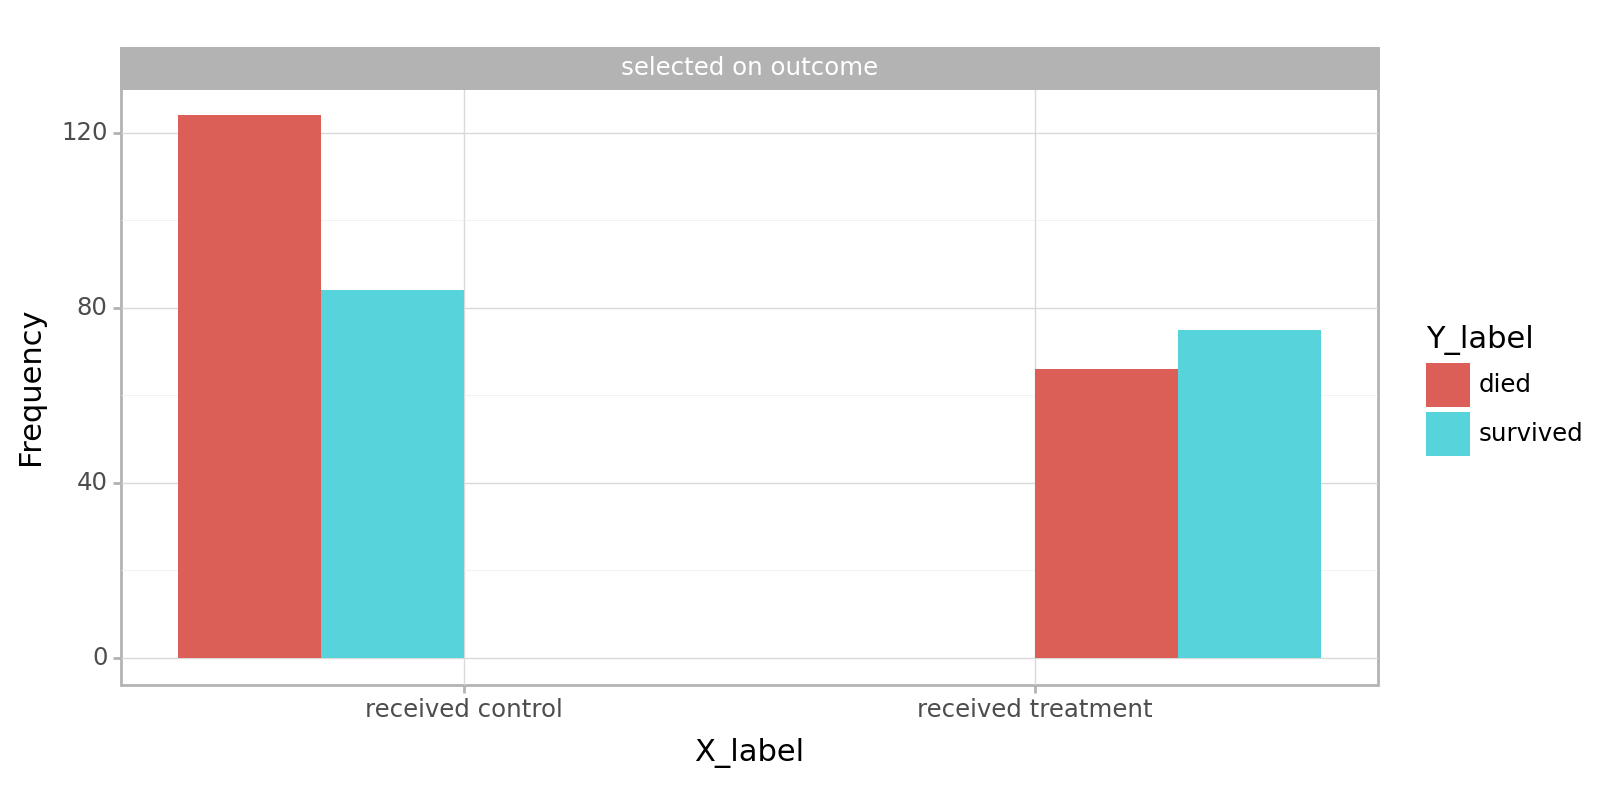

<Figure Size: (800 x 400)>

In [8]:
# generate informative variable names for plotting
data = data.assign(
    S_label = data.S.map({1 : "selected on outcome"}),
    X_label = data.X.map({0 : "received control", 1 : "received treatment"}),
    Y_label = data.Y.map({0 : "died", 1 : "survived"})
)

# create initial visualization
(
    pn.ggplot(data,
              pn.aes(x = "X_label",
                     fill = "Y_label"
                    )
             ) 
    + pn.facet_wrap("S_label")
    + pn.geom_histogram(binwidth = 1, position = 'dodge')
    + pn.ylab("Frequency")
    + pn.theme_light()
)

---

## 1.b. Prepare summary statistics

Finally, we will preprocess the data. `autobounds` works with sufficient statistics that represent the proportion of units with each unique combination of values, so we will first compute these.

In [9]:
# count units with each unique combination of Z, X, Y 
data_summary = (
    data
    .loc[:, ['S', 'X', 'Y']]
    .value_counts()
    .rename('counts')
    .reset_index()
)
data_summary

,S,X,Y,counts
0,1,0,0,124
1,1,0,1,84
2,1,1,1,75
3,1,1,0,66


In [10]:
# divide by the total to get the estimated probability of each type
data_summary = data_summary.assign(prob = data_summary.counts / 1000)
data_summary

,S,X,Y,counts,prob
0,1,0,0,124,0.124
1,1,0,1,84,0.084
2,1,1,1,75,0.075
3,1,1,0,66,0.066


---

# 2. Assumptions and estimands

In this section, we provide brief discussion on assumptions and estimands involved with the estimation of a causal effect in this setting.

## 2.a. Why outcome selection is a problem

$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Pro}{\mathbb{P}}$
A key difference between confounding and selection bias is that randomization protects against confounding, but not against selection bias if the selection occurs *after* the randomization. Therefore, we always implicitly condition on presence in the sample, $S=1$, and such individuals may not be exchangeable with those where $S=0$, those lost to follow-up. However, the average treamtent effect among those in the sample,
$$
\tau = \E[Y(x=1) - Y(x=0) | S=1],
$$
does not adequately represent the true effect. In general, the average treatment effect (ATE),
$$
\tau = \E[Y(x=1) - Y(x=0)],
$$
cannot be point identified without additional assumptions, even when the treatment and outcome are confounded by known covariates.

---

## 2.b. Standard approaches to dealing with outcome selection

Two popular approaches for dealing outcome selection in RCTs are as follows:

1. Use an adequate design, e.g. use a case-control study
   * It is important to note, though, that no matter the meticulousness of the researcher, it is still possible for such studies to exhibit selection bias in such studies, due to oversampling, for example. 
   
2. Inverse probability weighting (IPW)
   * Here, each member of the population is inversely weighted with their propensity to be lost to follow-up, conditional on their treatment assigment and pre-treatment covariates (known elements which confound the treatment and outcome). Intuitively, this is done to create a pseudopopulation in which those who were not included in the oriignal sample are given representation by those similar to them (via the pre-treatment covariates.) However, we should note, that it is not always the case that the pre-treatment covariates are avaialble to us in an observational study meaning that IPW is not feasible.


## 2.c. Outcome selection in the context of `autobounds`

In this notebook, we are interested in the causal effect
$$
\tau = \E[Y(x=1) - Y(x=0)],
$$
in spite of the outcome selection. We will see that `autobounds` still permits the researcher to still derive an informative causal effect of the treatment on the outcome when faced with data that has suffered from outcome selection.

---

# 3. Computation of effects via `autobounds`

In this section, we demonstrate once again the use of `autobounds`. We demonstrate how to compute sharp bounds on the original quantity of interest, the ATE, using only assumptions that are substantively justified. We also illustrate how `autobounds` can detect violations of assumptions that would be missed by traditional methods.

## 3.a. Bounding the ATE under plausible assumptions

In this section, we will present a step-by-step demonstration of `autobounds`. As a working example, we will compute sharp bounds on the original quantity of interest, the ATE, under the belief that treatment assignment may be confounded with the outcome, but does not directly cause loss to follow-up; however, it is assumed that there is a causal link between the experienced outcome of an individual and their loss to follow-up.

Both of these assumptions may be encapsulated by an appropriate DAG, which we implement first.

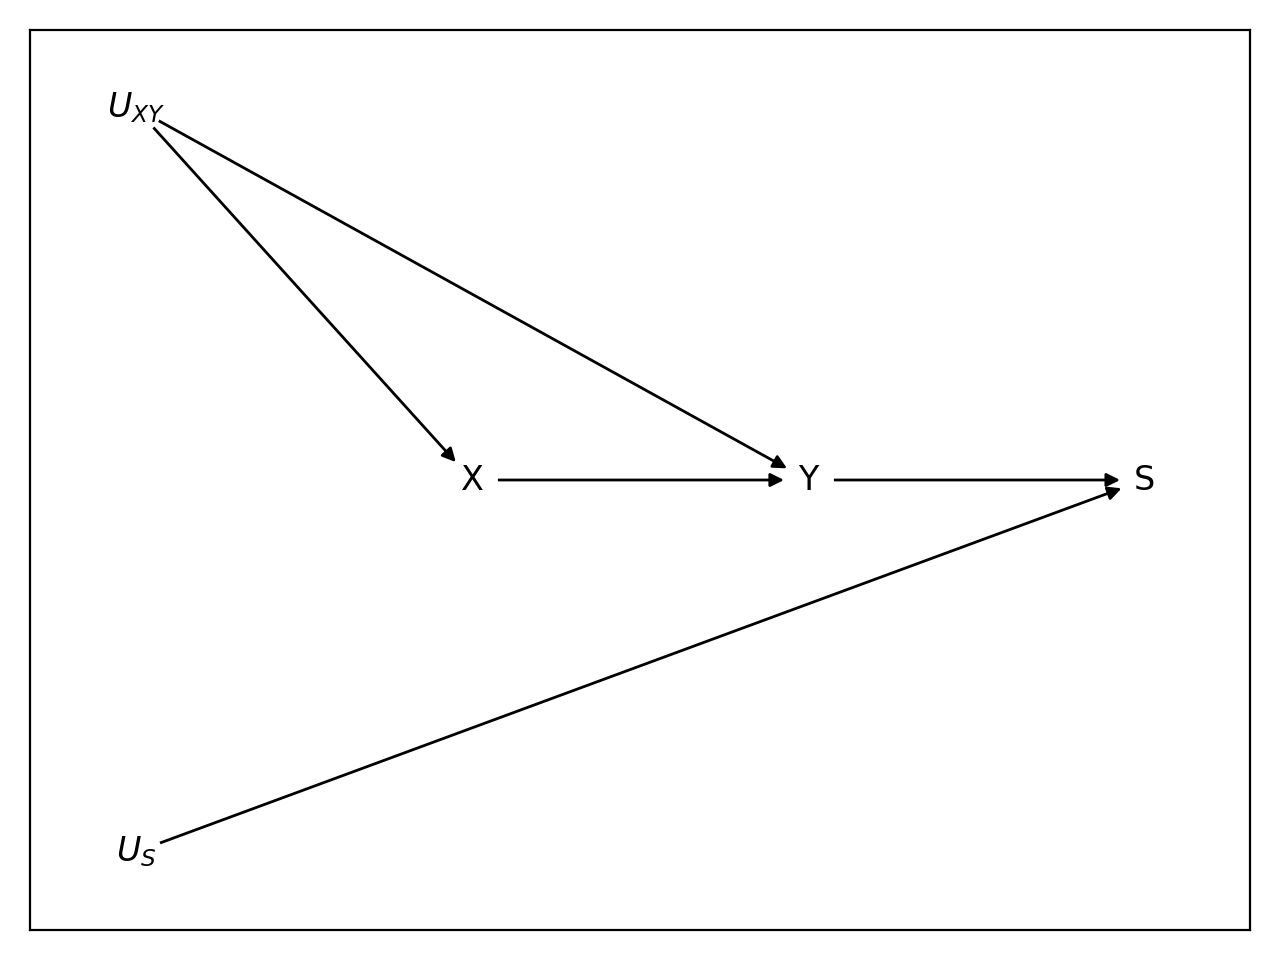

In [11]:
# first initialize an empty graph
graph = DAG()

# define edges and unobserved disturbances
graph.from_structure(
    edges = "Us -> S, Y -> S, X -> Y, Uxy -> X, Uxy -> Y",
    unob = "Us, Uxy"
)

# visualize the graph
graph.plot()

Second, we will tell `autobounds` about the causal-inference problem we would like to solve. A problem is defined by four elements:
- The causal graph, or structural assumptions relating the variables
- The sample space, or the number of unique values that each variable can take on
- Additional functional-form assumptions justified by domain expertise
- The empirical evidence, or the data
- The quantity of interest, or the estimand

We will begin with the `causalProblem()` constructor, which takes two arguments:
- `graph`: the causal structure that the problem involves
- `number_values` (optional): a dictionary in which keys are variable names and values are variable cardinalities (binary, ternary, etc.). E.g. `"{A : 2, B: 3}`. If left unspecified, all variables are assumed to be binary.

In [13]:
# initialize a causal-inference problem involving the iv dag
problem = causalProblem(
    graph,
    number_values = {"S" : 2, "X" : 2, "Y" : 2}  # for illustration (not needed, same as defaults)
)

After initializing this problem, we next add the assumptions that `autobounds` should use. Currently, we only need to tell `autobounds` about the laws of probability. This is done with the `.add_prob_constraints()` method.

In [14]:
# tell autobounds about the laws of probability
# (in a future update this will be handled automatically)
problem.add_prob_constraints()

The next step is to tell `autobounds` about the empirical evidence. The `.load_data()` method accepts summary statistics in the form of a `pandas` `DataFrame` object or a path to a CSV file. Regardless of the input format, this must contain (i) one column per variable measured in the dataset, (ii) one row per unique combination of values, and (iii) an additional column named "prob" indicating the proportion of units of this type. An example is given in `data_summary` above.

In [15]:
# load in the data
problem.load_data(data_summary)

The last step is to define the quantity of interest: the ATE of actually receiving treatment $X$ on outcome $Y$. Below, two arguments are provided to the `.set_ate()` method:
- `ind`: the name of the independent variable, or treatment
- `dep`: the name of the dependent variable, or outcome

In [16]:
problem.set_ate(ind = "X", dep = "Y")

Finally, we are ready to compute bounds. To do so, we will first translate the completely specified causal-inference problem into an equivalent *optimization program*. Solving this program with a numeric optimizer (like SCIP in the example below) will produce the desired sharp bounds.

In [17]:
# translate causal inference problem into optimization program
program = problem.write_program()

# run optimisation routine, argument saves results at filename
results = program.run_scip()

# examine complete output
# - "dual" bounds are guaranteed-valid causal bounds on the estimand
# - "primal" bounds are used to evaluate the sharpness of those bounds
# when the duals are equal to the primals, the reported bounds are perfectly sharp
# for more details, including the interpretation of theta and epsilon, see Duarte et al (2023)
results

In [378]:
"Based on these data and assumptions, the ATE is in the range [{lower:0.3f}, {upper:0.3f}]".format(
    lower = results[0]["dual"],  # index [0] selects lower bound, key ["dual"] selects guaranteed-valid bound
    upper = results[1]["dual"],  # index [1] selects upper bound, key ["dual"] selects guaranteed-valid bound
)

In other words, based on plausible assumptions, analysts cannot conclude that there is any effect of the treatment on outcome in this setting.

# References

Guilherme Duarte, Noam Finkelstein, Dean Knox, Jonathan Mummolo, and Ilya Shpitser. 2023. "An Automated Approach to Causal Inference in Discrete Settings," *Journal of the American Statistical Association* (Theory and Methods). https://doi.org/10.1080/01621459.2023.2216909

Miguel Hernan, James Robins. 2020. Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.